In [9]:
from typing import Union
from collections.abc import Iterable

import torch
import torch.nn.functional as F

from tools.plot.im import imshow_all
from detection.LMSG.ShapeOptimizer import ShapeOptimizer
from tools.gaussian.SpotVector import GaussSpot
from tools.gaussian.distance import wasserstein_distance_squared
from tools.gaussian.gen import generate, TruncGaussParams

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# retreive sample image here; 
SIZE = 64
images = generate(SIZE, 10, sig=TruncGaussParams(range=(0.3, 2), mu=1,sig=1)).sum_image(SIZE)

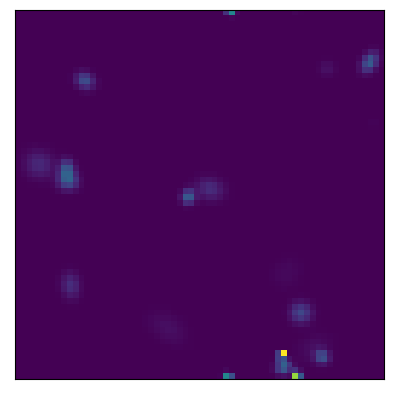

In [11]:
image = images[8]
imshow_all(image)

In [12]:
image = image.squeeze(-1)

opt = ShapeOptimizer(image)
opt.init_spots()
centers = opt.get_centers()


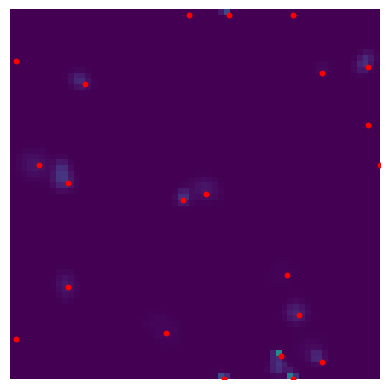

In [13]:
import matplotlib.pyplot as plt
import matplotlib.markers as mks

def imshow_diff(image, prediction):
    plt.axis("off")
    plt.imshow(prediction - image, vmax=1, vmin=-1)
    plt.show()

def imshow_with_points(image, centers):
    plt.axis("off")
    plt.imshow(image, vmax=1, vmin=0)
    marker = mks.MarkerStyle(marker='o')
    plt.scatter(centers[...,1], centers[...,0], 10, c="red", marker=marker)
    plt.show()

imshow_with_points(image, centers.detach())


early stop 120
MSE image loss:  6.395916716428474e-05
Max pixel-wise difference:  tensor(0.2255)


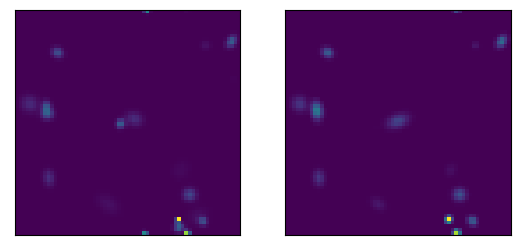

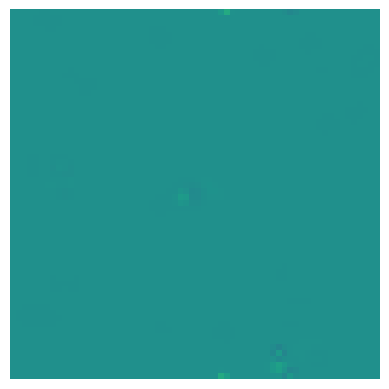

In [14]:
opt.optimize(lr=1, avg_loss_stop = 1e-20, avg_loss_stop_n=10)
modeled_image = opt.spots_image()

loss = F.mse_loss(modeled_image, image)
max_pixel_diff = torch.abs(modeled_image-image).max()


print("MSE image loss: ", loss.item())
print("Max pixel-wise difference: ", max_pixel_diff)
imshow_all(image, modeled_image)
imshow_diff(modeled_image, image)


# Metrics Evaluation

In [15]:
from cmath import isnan
import scipy
import time

def find_pairs(spots1, spots2):
    distances = torch.cdist(spots1.mu.unsqueeze(0), spots2.mu.unsqueeze(0)).squeeze(0)
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(distances)
    return spots1[row_ind], spots2[col_ind], distances

def calc_two_sets_accuracy(prediction: GaussSpot, target: GaussSpot, d_max=3.):
    metrics = {}
    sp_target, sp_pred, distances = find_pairs(target, prediction)
    dist = ((sp_target.mu - sp_pred.mu)**2).sum(-1)
    ok_pairs = dist < d_max**2
    sp_target, sp_pred = sp_target[ok_pairs], sp_pred[ok_pairs]
    metrics["dist_loss"] = F.mse_loss(sp_pred.mu, sp_target.mu) if torch.numel(sp_target.tensor) > 0 else 0

    #sometimes dist has 'nan' value TODO!: fix 
    w_dist2 = wasserstein_distance_squared(sp_pred.mu, sp_target.mu, sp_pred.sigD, sp_target.sigD)
    metrics["shape_loss"] = w_dist2.mean().item()  if torch.numel(w_dist2) > 0 else 0

    metrics["false_positive"] = max(len(prediction) - len(sp_pred), 0)
    metrics["false_negative"] = max(len(target) - len(sp_pred), 0)
    return metrics

In [7]:
def calculate_metrics(
    data: Iterable[Union[torch.Tensor, GaussSpot]],
    threshold=0.,
    lr=1,
    avg_loss_stop = 1e-10,
    avg_loss_stop_n=5,
):
    metrics = {
        "time": 0.,
        "image_loss": 0.,
        "false_positive": 0.,
        "false_negative": 0.,
        "dist_loss": 0.,
        "shape_loss": 0.,
    }
    n = 0.
    for input in data:
        n+=1
        input_image = input.sum_image(SIZE) if isinstance(input, GaussSpot) else input
        
        start_time = time.perf_counter()

        opt = ShapeOptimizer(input_image)
        opt.init_spots(threshold=threshold)
        # TODO: dependency of image_loss on lr/early_stop
        opt.optimize(lr=lr, avg_loss_stop = avg_loss_stop, avg_loss_stop_n=avg_loss_stop_n)

        end_time = time.perf_counter()
        metrics["time"] += end_time-start_time

        modeled_image = opt.spots_image()

        metrics["image_loss"] += F.mse_loss(modeled_image, image).item()

        if isinstance(input, GaussSpot): # ground truth spot set
            spots = opt.spots
            spots_predicted = spots[spots.intensity>0.01]
            set_metrics = calc_two_sets_accuracy(spots_predicted, input)
            for k, v in set_metrics.items():
                metrics[k] += v
    for k, v in metrics.items():
        metrics[k] = v/n
    return metrics


In [10]:
spot_sets = [ generate(SIZE) for _ in range(10) ]

metrics = calculate_metrics(spot_sets)

##TODO: plot charts by different algo parameters


early stop 25
early stop 17
early stop 11
early stop 17
early stop 36
early stop 53
early stop 29
early stop 16
early stop 25
early stop 25


In [11]:
print(metrics)

{'time': 0.16693596689999596, 'image_loss': 0.0008770925313001498, 'false_positive': 6.3, 'false_negative': 5.3, 'dist_loss': tensor(0.3436), 'shape_loss': nan}
